In [102]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler
from meteostat import Point, Daily, Hourly, Stations
import torch



In [103]:

lat = 47.6
lon = -122.3

# Define start and end times
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 1, 1)

data = Hourly(Point(lat,lon), start=start, end=end).fetch()

# Find how much data we have
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87673 entries, 2012-01-01 00:00:00 to 2022-01-01 00:00:00
Freq: H
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    87673 non-null  float64
 1   dwpt    87673 non-null  float64
 2   rhum    87673 non-null  float64
 3   prcp    87098 non-null  float64
 4   snow    0 non-null      float64
 5   wdir    86382 non-null  float64
 6   wspd    87673 non-null  float64
 7   wpgt    0 non-null      float64
 8   pres    87672 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    34425 non-null  float64
dtypes: float64(11)
memory usage: 8.0 MB


In [104]:
# Extract all relevant channels and impute and missing values
data_cleaned = data[['temp', 'dwpt', 'prcp', 'wspd', 'wdir','pres']]
print(data_cleaned.isna().any())

# Use linear interpolation to fill in NA values
data_cleaned['temp'].interpolate(method='linear', inplace=True)
data_cleaned['dwpt'].interpolate(method='linear', inplace=True)
data_cleaned['prcp'].interpolate(method='linear', inplace=True)
data_cleaned['wspd'].interpolate(method='linear', inplace=True)
data_cleaned['wdir'].interpolate(method='linear', inplace=True)
data_cleaned['pres'].interpolate(method='linear', inplace=True)
print(data_cleaned.isna().any())

temp    False
dwpt    False
prcp     True
wspd    False
wdir     True
pres     True
dtype: bool
temp    False
dwpt    False
prcp     True
wspd    False
wdir    False
pres    False
dtype: bool


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [105]:
timeseries = data_cleaned[['temp']].values.astype('float32')

scaler = StandardScaler()

scaler.fit(timeseries)

timeseries=scaler.transform(timeseries)

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [106]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [107]:
# def create_dataset(dataset, lookback, horizon):
#     """Transform a time series into a prediction dataset
    
#     Args:
#         dataset: A numpy array of time series, first dimension is the time steps
#         lookback: Size of window for prediction
#     """
#     X, y = [], []
#     for i in range(lookback, len(dataset) - horizon, 1):
#         feature = dataset[i - lookback : i]
#         target = dataset[i : i + horizon]
#         X.append(feature)
#         y.append(target)
#     return torch.tensor(X), torch.tensor(y)

In [108]:
lookback = 24
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [109]:
class TempModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = torch.nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = torch.nn.Linear(50, 1)
        self.lstm2 = torch.nn.LSTM(25, 1)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.linear(x)
        return x

In [110]:
model = TempModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=512)

In [111]:
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # # Validation
    # if epoch % 100 != 0:
    #     continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.3181, test RMSE 0.3209
Epoch 1: train RMSE 0.2187, test RMSE 0.2189
Epoch 2: train RMSE 0.1836, test RMSE 0.1836
Epoch 3: train RMSE 0.1618, test RMSE 0.1615
Epoch 4: train RMSE 0.1468, test RMSE 0.1464
Epoch 5: train RMSE 0.1370, test RMSE 0.1363
Epoch 6: train RMSE 0.1307, test RMSE 0.1298
Epoch 7: train RMSE 0.1268, test RMSE 0.1261
Epoch 8: train RMSE 0.1231, test RMSE 0.1224
Epoch 9: train RMSE 0.1220, test RMSE 0.1214


In [118]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    print(y_pred.shape)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

torch.Size([58716, 24, 1])


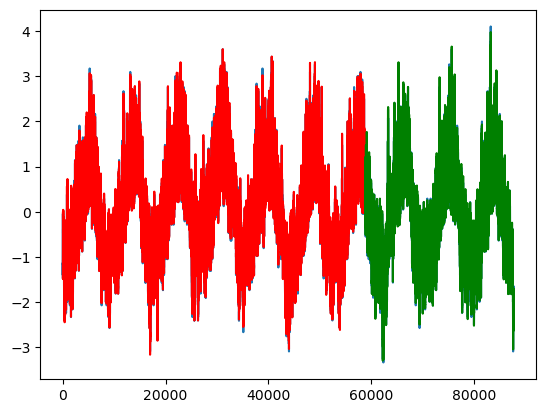

In [113]:
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [121]:
timeseries.shape

(87673, 1)

In [120]:
with torch.no_grad():
    # shift train predictions for plotting
    last_day = np.ones_like(timeseries[-1, :]) * np.nan
    y_pred = model(X_test)
    print(y_pred.shape)
    y_pred = y_pred[-1, :, :]
    last_day[]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


torch.Size([58716, 24, 1])
